# Generating galaxies with GalSim

We are using the same GalSim routine as for the [asymmetry project](https://github.com/astro-nova/asymmetry) with some changes to make the galaxies more realistic in terms of the size and distribution of the random clumps that are added. These generation functions are then saved to `galaxy_generator.py`.

#### Imports

In [5]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

# Astropy
import pandas as pd
from astropy.io import fits
from astropy.visualization import AsinhStretch, AsymmetricPercentileInterval

# Galsim
from galaxy_generator import simulate_perfect_galaxy, add_source_to_image, sky_noise, get_galaxy_rng_vals

Load in a galaxy to compare our generated galaxies to. This is an HSC i-band observation.

In [6]:
gal_f = fits.open('data/J000318+004844.fits')
gal = gal_f[0].data

pxscale = 0.169
zp = 2.5*np.log10(gal_f[0].header['FLUXMAG0'])
gal_f.close()

Plot it using both the SB and the asinh stretch:

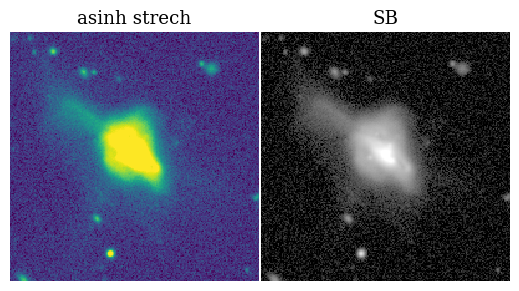

In [7]:
stretch = AsinhStretch(0.1)
norm = AsymmetricPercentileInterval(1, 99.6)
fig, axs = plt.subplots(1,2, figsize=(5,2.5))
axs[0].imshow(stretch(norm(gal)))
axs[1].imshow(-2.5*np.log10(np.abs(gal)/pxscale**2)+zp, cmap='gray_r', vmin=20, vmax=27)
axs[0].set_title('asinh strech')
axs[1].set_title('SB')
for ax in axs: 
    ax.axis('off')
    ax.set_xlim(238-100,238+100)
    ax.set_ylim(238-100,238+100)
plt.subplots_adjust(wspace=0.01)

## Generating a galaxy

### Changes from the Asymmpetry paper

#### More realistic clumps

* Clumps get fainter with radius away from the center as $(r/R_p)^\alpha$ 
    * $\alpha$ is something we can decide on. $\alpha \approx 2$ would follow a similar profile to the galaxy light; but we want asymmetric clumps to be a little flatter than that
    * Clump brightness is determined by *surface brightness* not *total flux* so that large clumps are not always much fainter than small ones. This would mean that the flux is distribution as $(r_{clump}/r_0)^2$ where $r_0$ is a typical clump size. 
    * However, we do want the clumps to be a little biased since large tidal features are typically faint, so we want some bias factor $(r_{clump}/r_0)^\beta$.
    
Overall, the clump flux $F$ is scaled by 

$$ F \propto \left( \frac{r}{R_p} \right)^{-\alpha} \left( \frac{r_{clump}}{r_0} \right)^{2-\beta}$$

The procedure is then:

1. Draw the fraction of the galaxy's total light contained in the clump, $f$, and radius, $r$.
2. Scale it up/down based on the clump radius itself (third bias)
3. Scale it down based on the radius from the galaxy center (first bias)
4. Calculate the total flux of the clump or pass the resulting fraction

Also, we now generate clumps to have logarithmically spaced sizes.

Finally, we now incline the clumps with the galaxy, and change their coordinates to reflect the tilt in the parent light distribution -- so the clumps are more similar to SF clumps and less similar to companions (since we add a companion function later on).

New clump generator function -- in `get_galaxy_rng_vals`, change

Generate and plot a galaxy:

In [8]:
pxscale = 0.1

params = get_galaxy_rng_vals(1, seed=100)[0]
# params['comp_properties']['flux_frac']=2
# params['comp_properties']['r']=2
img, sim_dict, rpet = simulate_perfect_galaxy(pxscale=pxscale, **params)
img, skylevel = sky_noise(img, 23, pxscale, rms_noise=True)

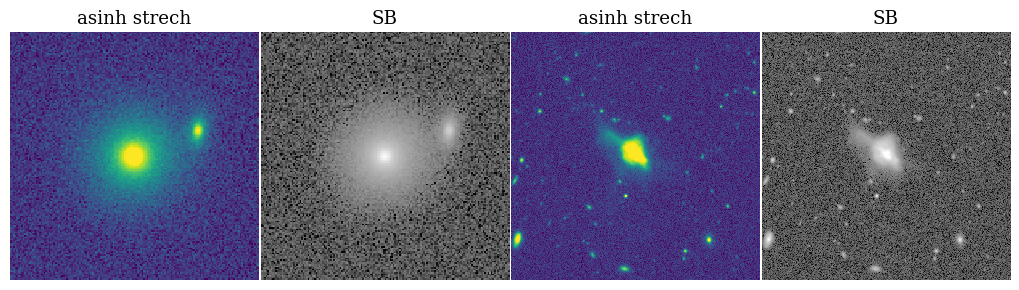

In [9]:
stretch = AsinhStretch(0.1)
norm = AsymmetricPercentileInterval(1, 99.6)
fig, axs = plt.subplots(1,4, figsize=(10,2.5))
axs[0].imshow(stretch(norm(img)))
axs[1].imshow(-2.5*np.log10(np.abs(img)/pxscale**2)+38, cmap='gray_r', vmin=17, vmax=27)
axs[2].imshow(stretch(norm(gal)))
axs[3].imshow(-2.5*np.log10(np.abs(gal)/0.04**2)+zp, cmap='gray_r', vmin=17, vmax=27)
axs[0].set_title('asinh strech')
axs[2].set_title('asinh strech')
axs[1].set_title('SB')
axs[3].set_title('SB')
for ax in axs: 
    ax.axis('off')
plt.subplots_adjust(wspace=0.01)

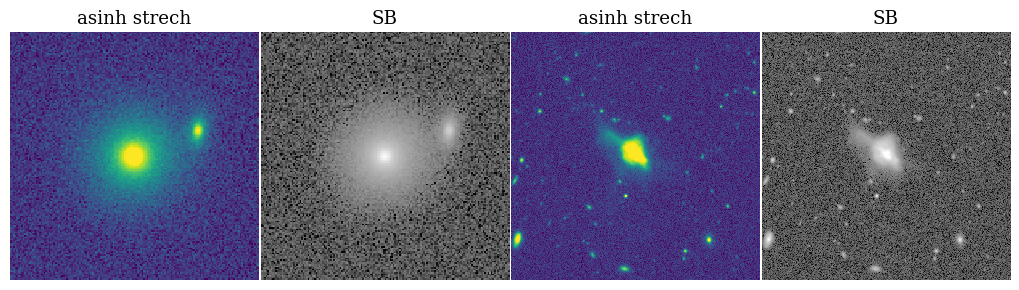

In [10]:
stretch = AsinhStretch(0.1)
norm = AsymmetricPercentileInterval(1, 99.6)
fig, axs = plt.subplots(1,4, figsize=(10,2.5))
axs[0].imshow(stretch(norm(img)))
axs[1].imshow(-2.5*np.log10(np.abs(img)/pxscale**2)+38, cmap='gray_r', vmin=17, vmax=27)
axs[2].imshow(stretch(norm(gal)))
axs[3].imshow(-2.5*np.log10(np.abs(gal)/0.04**2)+zp, cmap='gray_r', vmin=17, vmax=27)
axs[0].set_title('asinh strech')
axs[2].set_title('asinh strech')
axs[1].set_title('SB')
axs[3].set_title('SB')
for ax in axs: 
    ax.axis('off')
plt.subplots_adjust(wspace=0.01)

They look similar enough -- let's continue with this galaxy generation method.

#### 2-component Sersic profiles

We want to test the B/T decomposition performance, so let's generate galaxies with two Sersic profiles. We do it as follows:

1. Select a B/T (bulge-to-total flux ratio) value between 0 and 1.
2. Draw two Sersic indices for the two components
    * Disk: a random index $1\leq n \leq 2.5$
    * Bulge: a random index $2.5 \leq n < 5$
3. Draw a random effective radius as before.
4. Draw a secondary effective radius
    * Random: $0.1R_{\rm{eff}} \leq R_{\rm{eff,2}} \leq R_{\rm{eff}}$
5. Select the primary and the secondary components
    * If $\textrm{B/T} > 0.5$ then $R_{\rm{bulge}} = R_{\rm{eff}}$ and $R_{\rm{disk}} = R_{\rm{eff,2}}$
    * If $\textrm{B/T} \leq 0.5$ then $R_{\rm{disk}} = R_{\rm{eff}}$ and $R_{\rm{bulge}} = R_{\rm{eff,2}}$
6. Tilt the disk component conserving flux; do not tilt the bulge component.


In `get_galaxy_rng_vals`, generate the parameters for the two-Sersic model as

In `simulate_perfect_galaxy`, change the parameters that get passed to the function to include the two-sersic model.

In `gen_galaxy`, add the two-Sersic model:

### Companion

Finally, we add a possibility of a companion to make sure some galaxies have asymmetric *shapes*. Imitating tidal tails is difficult (skimage has a `swirl` transform but it only produces symmetric "tidal" features), but adding another Sersic companion can do the trick.

1. Draw a random number between 0 and 1 and compare to `companion_threshold` ($0.3$). If less than that, generate the companion.
2. As for clumps, generate $r$ and $\theta$ where the companion is placed
    * $r$ : $0.7 < r/R_p < 1.5$
3. Generate random values for the companion Sersic profile. Restrict it to be a disk (for simplicity).
    * $n$: $1 < n < 3$
    * Flux: a fraction of the parent flux between 0.3 and 0.7 (ensuring the companion is somewhat bright)
    * $R_{\rm{eff}}$: a fraction of the parent $R_p$ between 0.2 and 0.5
    * $q$ : $0 < q < 1$
    * Angle with respect to the image x-axis between 0 and 2$\pi$
    * Orientation angle of the companion between 0 and 2$\pi$
    
Then generate the clump as normal.

Plot some example galaxies:

In [276]:
pxscale = 0.1

params = get_galaxy_rng_vals(1, seed=3)[0]
params['warp_strength']=2
params['n_clumps'] = 0
params['clump_properties'] = {'r' : [], 'theta' : [], 'flux_frac' : [],  'sigma' : []}
img, sim_dict, rpet = simulate_perfect_galaxy(pxscale=pxscale, **params)
img, skylevel = sky_noise(img, 23, pxscale, rms_noise=True)

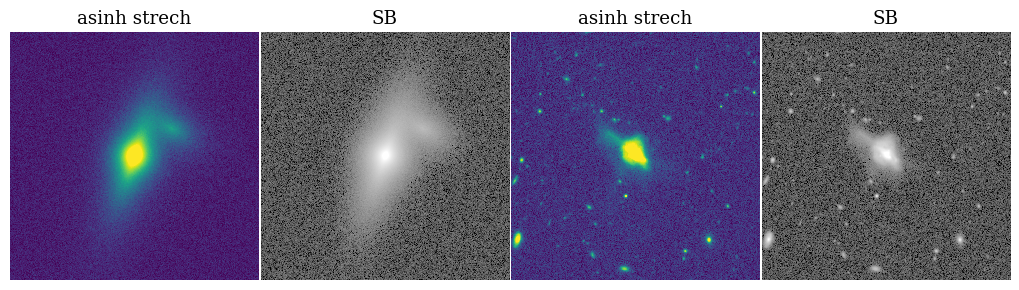

In [277]:
stretch = AsinhStretch(0.1)
norm = AsymmetricPercentileInterval(1, 99.6)
fig, axs = plt.subplots(1,4, figsize=(10,2.5))
axs[0].imshow(stretch(norm(img)))
axs[1].imshow(-2.5*np.log10(np.abs(img)/pxscale**2)+38, cmap='gray_r', vmin=17, vmax=27)
axs[2].imshow(stretch(norm(gal)))
axs[3].imshow(-2.5*np.log10(np.abs(gal)/0.04**2)+zp, cmap='gray_r', vmin=17, vmax=27)
axs[0].set_title('asinh strech')
axs[2].set_title('asinh strech')
axs[1].set_title('SB')
axs[3].set_title('SB')
for ax in axs: 
    ax.axis('off')
plt.subplots_adjust(wspace=0.01)